In [ ]:
print ("hello world")

In [27]:
# %load ../train_and_append_boosted.py
import statistics
import collections
import getopt, sys
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace
import pandas
import math
from sklearn.preprocessing import StandardScaler
import root_numpy
from ROOT import gSystem
from root_numpy import root2array, array2tree
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import plot_model
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ROOT

In [28]:
class MyDict(collections.OrderedDict):
    def __missing__(self, key):
        val = self[key] = MyDict()
        return val


In [42]:
appendListLocation = "../datasets_to_append/"
nnLocation = "./"

branchList = ["pT_hh",
              "nMuon", "nElec",
              "h1_M", "h1_Pt", "h1_Eta", "h1_Phi", "h1_j1_j2_dR",
              "h2_M", "h2_Pt", "h2_Eta", "h2_Phi", "h2_j1_j2_dR",
              "met_Et", "met_Phi", 
              "h1_j1_BTag","h1_j2_BTag","h2_j1_BTag","h2_j2_BTag",
              "mc_sf"]
nFeatures = len(branchList)-1


# Name of the tree we want to use
inTreeName = "preselection"

In [43]:
#for analysis in ["resolved", "intermediate", "boosted"]:
analysis = "intermediate"
inFileList = "tst_sig_intermediate.txt"

branchList = ["pT_hh",
              "nMuon", "nElec",
              "h1_M", "h1_Pt", "h1_Eta", "h1_Phi", "h1_j1_j2_dR",
              "h2_M", "h2_Pt", "h2_Eta", "h2_Phi", "h2_j1_j2_dR",
              "met_Et", "met_Phi", 
              "h1_j1_BTag","h1_j2_BTag","h2_j1_BTag","h2_j2_BTag",
              "mc_sf"]
nFeatures = len(branchList)-1    
scoreBranch = MyDict()


In [44]:
nnFilepath = nnLocation + "testingAppend.h5"
scalerFilepath = nnLocation + "scaler_testingAppend.sav"

inFilepath0 = "/home/paredes/pheno/testnn/pheno_study/utilities/SplitROOT/OxHHPh_06May2019_MG5_262_Py8_14TeV_NNPDF30NLO_Dlph3_pp2hh_4b_HeavyHiggsTHDM_TopYuk_1.0_SlfCoup_1.0_merged_ntup.root.intermediate_0.root"
inFilepath1 = "/home/paredes/pheno/testnn/pheno_study/utilities/SplitROOT/OxHHPh_06May2019_MG5_262_Py8_14TeV_NNPDF30NLO_Dlph3_pp2hh_4b_HeavyHiggsTHDM_TopYuk_1.0_SlfCoup_1.0_merged_ntup.root.intermediate_1.root"
inFilepath2 = "/home/paredes/pheno/testnn/pheno_study/utilities/SplitROOT/OxHHPh_06May2019_MG5_262_Py8_14TeV_NNPDF30NLO_Dlph3_pp2hh_4b_HeavyHiggsTHDM_TopYuk_1.0_SlfCoup_1.0_merged_ntup.root.intermediate_2.root"
inFilepath3 = "/home/paredes/pheno/testnn/pheno_study/utilities/SplitROOT/OxHHPh_06May2019_MG5_262_Py8_14TeV_NNPDF30NLO_Dlph3_pp2hh_4b_HeavyHiggsTHDM_TopYuk_1.0_SlfCoup_1.0_merged_ntup.root.intermediate_3.root"

# Load the input file and grab the data from it.
inArray0 = root2array(inFilepath0, branches=branchList, treename=inTreeName)
inArray1 = root2array(inFilepath1, branches=branchList, treename=inTreeName)
inArray2 = root2array(inFilepath2, branches=branchList, treename=inTreeName)
inArray3 = root2array(inFilepath3, branches=branchList, treename=inTreeName)
#inFile = ROOT.TFile.Open(inFilepath)
#inTree = inFile.Get(inTreeName)

# Silly hack to remove stuctured dtype
inDF0 = pandas.DataFrame(inArray0)
inDF1 = pandas.DataFrame(inArray1)
inDF2 = pandas.DataFrame(inArray2)
inDF3 = pandas.DataFrame(inArray3)
inDF = inDF0
inDF = inDF.append(inDF1)
inDF = inDF.append(inDF2)
inDF = inDF.append(inDF3)

inDF = shuffle(inDF)
evtWeights = inDF.pop("mc_sf")

print ("-------------------------array head",inDF.head())

inArray = inDF.values
print("-------------------------array.values no mc_sf", inArray[:10])

# Scale input features to mean=0, stddev=1
#scaler = joblib.load(scalerFilepath)
scaler = StandardScaler().fit(inArray)
inArray_scaled = scaler.fit_transform(inArray)

print("-------------------------array after scaler",inArray_scaled[:10])

# Load the NN from file
model = keras.models.load_model(nnFilepath)

# Run validation sample through the NN
scores = model.predict(inArray_scaled)
print("-------------------------SCORES",scores)

# Gonvert to 1D basig python aggays
# 0 == signal; 1 == qcd; 2 == ttbar
scores_sig = scores[:,0].tolist()
scores_qcd = scores[:,1].tolist()
scores_top = scores[:,2].tolist()
print("mean sig score = ", statistics.mean(scores_sig))
print("mean qcd score = ", statistics.mean(scores_qcd))
print("mean top score = ", statistics.mean(scores_top))
# Give it the correct numpy array structure for a branch
scoreBranch["sig"] = np.array(scores_sig, dtype=[('nnscore_sig', np.float32)])
scoreBranch["qcd"] = np.array(scores_qcd, dtype=[('nnscore_qcd', np.float32)])
scoreBranch["top"] = np.array(scores_top, dtype=[('nnscore_top', np.float32)])

-------------------------array head             pT_hh  nMuon  nElec        h1_M       h1_Pt    h1_Eta    h1_Phi  \
6700   130.429830      0      0   83.836945  300.956085  1.705306  2.784479   
11093   52.916580      0      0   77.851471  268.088440 -0.845061 -1.265199   
5126     2.769688      0      0   90.263786  263.853302 -0.648472  1.650255   
1356   128.295550      0      0  118.482887  253.944641  0.718268  0.421515   
7467   345.712285      0      0  121.127342  406.262329  0.027286  3.050629   

       h1_j1_j2_dR        h2_M       h2_Pt    h2_Eta    h2_Phi  h2_j1_j2_dR  \
6700      0.323660  269.609725  201.011523 -0.766970 -0.699505     1.884937   
11093     1.572333  219.465773  217.792807 -0.822167  1.808314     1.782864   
5126      0.603967  446.938056  266.398545 -0.173337 -1.487218     2.790592   
1356      0.867205   83.071405  143.293231  0.640345 -3.062126     1.119389   
7467      0.611357  247.595690   84.558608  1.556122 -0.787953     3.063598   

          met_

In [45]:
scaled_mean = statistics.mean(inArray_scaled[:,0])
print("scaled pt_hh mean",scaled_mean)
print("pt_hh mean",statistics.mean(inArray[:,0]))

scaled pt_hh mean 2.4882030386680003e-17
pt_hh mean 161.2232244582874


In [46]:
# Format data for convenience
appendData = pandas.DataFrame(inArray)
appendData['sig_score'] = pandas.Series(scores[:,0], index=appendData.index)
appendData['qcd_score'] = pandas.Series(scores[:,1], index=appendData.index)
appendData['top_score'] = pandas.Series(scores[:,2], index=appendData.index)


print("signal score mean = ", statistics.mean(appendData['sig_score']))
print("   QCD score mean = ", statistics.mean(appendData['qcd_score']))
print(" ttbar score mean = ", statistics.mean(appendData['top_score']))

signal score mean =  0.289199344849176
   QCD score mean =  0.4201384523476554
 ttbar score mean =  0.2906622026286626


Text(0,0.5,'1/N dN/d(NN Score)')

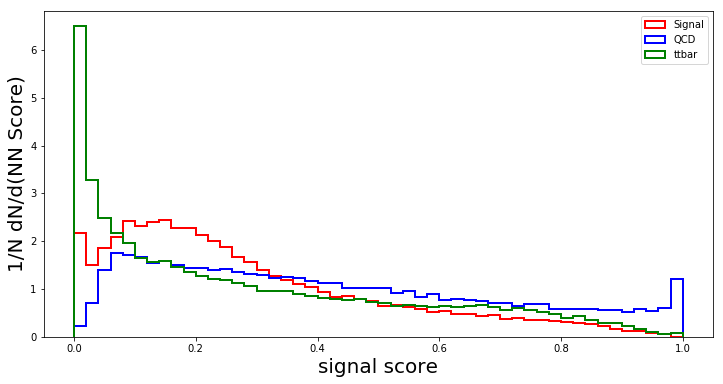

In [47]:
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(appendData['sig_score'], color=["r"], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData['qcd_score'], color=["b"], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData['top_score'], color=["g"], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

In [ ]:
    nFeatures = len(branchList)-1


In [ ]:
# This program trains a neural network based on input numpy array files.
# Output is one trained NN file (nn_*.h5) and one scaler file (scaler_*.sav)
# per analysis. Optionally also makes plots of the output distributions for the
# training sample.

### NOTE this program uses 0.2 of the data as a validation set

In [ ]:
# Path of the directory whit lits of ntuples to append score to
fileListLocation = "test_append.txt"
# Path of the directory containing .npz files to train on.
# Standard naming convention is assumed (e.g. "trainingData_resolved.npz")
trainingDataPath = "../train_all_jets/"

In [ ]:
# Training parameters
numEpochs = 10
batchSize = 100
dropoutFraction = 0.3
# initial learning rate for adamax
init_lr = MyDict()
init_lr["boosted"] = 5e-5
init_lr["intermediate"] = 5e-3
init_lr["resolved"] = 5e-3

# store parameters of the network in a string
#param_string = "_w_OPadamaxEP"+str(numEpochs)+"BS"+str(batchSize)+"DO"+str(dropoutFraction).replace(".","")
# Plot score distributions for the training sample?
makePlots = False

target_nevents = 100000

signal_weight = MyDict()
ttbar_weight = MyDict()
qcd_weight = MyDict()
analysis = "intermediate"
param_string = "testSave_all_jets_LR"+str(init_lr[analysis]).replace("0.","0p")
print ("paramters string "+param_string)

In [ ]:
# Load the input file and grab the data from it.
# Label each type of background
# Calculate weight for each 'target' sample
#inFile = np.load(trainingDataPath + "/trainingData_all_jets_" + analysis + ".npz")

signalData = pandas.DataFrame(dat_sig)
#signalData = pandas.DataFrame(inFile["sig"])
signalData["target"] = 0
#signal_weight[analysis] = target_nevents/len(signalData)
print(len(signalData),"(",signal_weight[analysis],") signal (weight) events found")
n_sig = len(signalData)

signalAppendData = pandas.DataFrame(datAppend_sig)
signalAppendData["target"] = 0
print(len(signalAppendData),"(",signal_weight[analysis],") signal (weight) events found")
n_sig = len(signalAppendData)
signal_weight[analysis] = target_nevents/(len(signalData)+len(signalAppendData))


In [ ]:
backgroundData = pandas.DataFrame(dat_4b)
backgroundData["target"] = 1

backgroundAppend_4bData = pandas.DataFrame(datAppend_4b)
backgroundAppend_4bData["target"] = 1
backgroundData = backgroundData.append(backgroundAppend_4bData)
print(len(backgroundData), "4b background events found")

backgroundAppend_2b2j = pandas.DataFrame(datAppend_2b2j)
backgroundAppend_2b2j["target"] = 1
backgroundData = backgroundData.append(backgroundAppend_2b2j)

background_2b2j = pandas.DataFrame(dat_2b2j)
background_2b2j["target"] = 1
backgroundData = backgroundData.append(background_2b2j)
print(len(background_2b2j)+len(backgroundAppend_2b2j), "2b2j background events found")

n_qcd_bkg = len(backgroundData)+len(backgroundAppend_4bData)+len(background_2b2j)+len(backgroundAppend_2b2j)
qcd_weight[analysis] = target_nevents/n_qcd_bkg
print(n_qcd_bkg,"(",qcd_weight[analysis], ") qcd (weight) background events found")

In [ ]:
background_ttbar = pandas.DataFrame(dat_ttbar)
#background_ttbar = pandas.DataFrame(inFile["bkg_ttbar"])
background_ttbar["target"] = 2
ttbar_weight[analysis] = target_nevents/len(background_ttbar)
print(len(background_ttbar),"(",ttbar_weight[analysis], ") ttbar (weight) background events found")
backgroundData = backgroundData.append(background_ttbar)
n_ttbar = len(background_ttbar)

backgroundAppend_ttbar = pandas.DataFrame(datAppend_ttbar)
backgroundAppend_ttbar["target"] = 2
n_ttbar = len(background_ttbar)+len(backgroundAppend_ttbar)
ttbar_weight[analysis] = target_nevents/n_ttbar
print(n_ttbar,"(",ttbar_weight[analysis], ") ttbar (weight) background events found")
backgroundData = backgroundData.append(backgroundAppend_ttbar)


In [ ]:
allData = signalData.append(backgroundData, ignore_index = True)

# Set all event weights to 1 by default
allData.loc[:, 'mc_sf'] = 1.
# Apply manual event weighting: numbers that give "reasonable behavior"
allData.loc[allData.target == 0, 'mc_sf'] = signal_weight[analysis] # signal
allData.loc[allData.target == 1, 'mc_sf'] = qcd_weight[analysis]    # QCD
allData.loc[allData.target == 2, 'mc_sf'] = ttbar_weight[analysis]  # ttbar

allData = shuffle(allData)

In [ ]:
xTrainData = allData
procType = xTrainData.pop("target")


X_train, X_run, yTypeTrain, yTypeRun = train_test_split(xTrainData, procType, test_size=0.4, random_state=1)
X_train, X_test, yTypeTrain, yTypeTest = train_test_split(X_train, yTypeTrain, test_size=0.2, random_state=1)

# These aren't input features, separate them out.
evtWeightsTrain = X_train.pop("mc_sf")
evtWeightsVal = X_test.pop("mc_sf")
evtWeightsRun = X_run.pop("mc_sf")

# Convert pandas dataframes into numpy arrays
X_test = X_test.values
X_train = X_train.values
X_run = X_run.values
evtWeightsTrain = evtWeightsTrain.values
evtWeightsVal = evtWeightsVal.values
evtWeightsRun = evtWeightsRun.values
y_test = keras.utils.to_categorical(yTypeTest, num_classes=3)
y_train = keras.utils.to_categorical(yTypeTrain, num_classes=3)
yTypeTest = yTypeTest.values
yTypeTrain = yTypeTrain.values
yTypeRun = yTypeRun.values

In [ ]:
print(np.unique(yTypeTrain,return_counts=True))
print(np.unique(yTypeTest,return_counts=True))
print(np.unique(yTypeRun,return_counts=True))

In [ ]:
# Convert this into the right format for keras

# Scale input features to mean=0, stddev=1
classStd1 = StandardScaler().fit(X_train)
X_train = classStd1.fit_transform(X_train)
X_test = classStd1.fit_transform(X_test)
# scale run later
#X_run = classStd1.fit_transform(X_run)
#joblib.dump(classStd1, "scaler_" + analysis + param_string +".sav")

In [ ]:
# Construct the NN architecture
model = Sequential()
model.add(Dense(200, activation="relu", input_dim= nFeatures))#input_dim should be as long as the branchList given to the NN
model.add(Dropout(dropoutFraction))
model.add(Dense(200, activation="relu"))
model.add(Dense(3, activation="softmax")) # output nodes

model.compile(
        loss='categorical_crossentropy',  # we train 10-way classification
        optimizer=keras.optimizers.adamax(lr=init_lr[analysis]),  # for SGD
        metrics=['acc']  # report accuracy during training
        )

In [ ]:
# Train the NN
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=numEpochs, batch_size=batchSize, sample_weight=evtWeightsTrain,shuffle=True)
# no need to save model for now 
model.save("testingAppend.h5")

In [ ]:
# Run training sample back through the NN
probTrain = model.predict(X_train)
probTest = model.predict(X_test)

In [ ]:
# Construct discriminant
scores_train = np.log(probTrain[:,0]/(probTrain[:,1]+probTrain[:,2]))
scores_test = np.log(probTest[:,0]/(probTest[:,1]+probTest[:,2]))

# Format data for convenience
trainData = pandas.DataFrame(X_train)
trainData['sig_score'] = pandas.Series(probTrain[:,0], index=trainData.index)
trainData['qcd_score'] = pandas.Series(probTrain[:,1], index=trainData.index)
trainData['top_score'] = pandas.Series(probTrain[:,2], index=trainData.index)
trainData['disc'] = pandas.Series(scores_train, index=trainData.index)
trainData['weight'] = pandas.Series(evtWeightsTrain, index=trainData.index)
trainData['process'] = pandas.Series(yTypeTrain, index=trainData.index)

print("signal mean = ", statistics.mean(trainData[trainData.process == 0]['sig_score']))
print("   QCD mean = ", statistics.mean(trainData[trainData.process == 1]['sig_score']))
print(" ttbar mean = ", statistics.mean(trainData[trainData.process == 2]['sig_score']))

In [ ]:
testData = pandas.DataFrame(X_test)
testData['sig_score'] = pandas.Series(probTest[:,0], index=testData.index)
testData['qcd_score'] = pandas.Series(probTest[:,1], index=testData.index)
testData['top_score'] = pandas.Series(probTest[:,2], index=testData.index)
testData['disc'] = pandas.Series(scores_test, index=testData.index)
testData['weight'] = pandas.Series(evtWeightsVal, index=testData.index)
testData['process'] = pandas.Series(yTypeTest, index=testData.index)

In [ ]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(trainData[trainData.process == 0]['sig_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(trainData[trainData.process == 1]['sig_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(trainData[trainData.process == 2]['sig_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.hist(testData[testData.process == 0]['sig_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(testData[testData.process == 1]['sig_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(testData[testData.process == 2]['sig_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')
plt.title(analysis + " (training and validation samples)")
plt.figure(figsize=(12,6))
plt.hist(trainData[trainData.process == 0]['qcd_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(trainData[trainData.process == 1]['qcd_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(trainData[trainData.process == 2]['qcd_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.hist(testData[testData.process == 0]['qcd_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal(Val)', **hist_params)
plt.hist(testData[testData.process == 1]['qcd_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD(Val)', **hist_params)
plt.hist(testData[testData.process == 2]['qcd_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar(Val)', **hist_params)
plt.legend(loc='best')
plt.xlabel("qcd score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

In [ ]:
signalAppendData = pandas.DataFrame(datAppend_sig)


In [ ]:
print(np.unique(yTypeRun,return_counts=True))

In [ ]:
##append_mc_sf = signalAppendData.pop("mc_sf")
#append_mc_sf = X_run.pop("mc_sf")
#append_mc_sf = append_mc_sf.values
## Convert pandas dataframes into numpy arrays
## signalAppendData = signalAppendData.values
#X_run = X_run.values

In [ ]:
X_run_clone = X_run
appendData_clone = pandas.DataFrame(X_run_clone)

X_run = classStd1.fit_transform(X_run)


In [ ]:
# Run training sample back through the NN
probAppend = model.predict(X_run)

In [ ]:
# Format data for convenience
appendData = pandas.DataFrame(X_run)
appendData['sig_score'] = pandas.Series(probAppend[:,0], index=appendData.index)
appendData['qcd_score'] = pandas.Series(probAppend[:,1], index=appendData.index)
appendData['top_score'] = pandas.Series(probAppend[:,2], index=appendData.index)
appendData['weight'] = pandas.Series(evtWeightsRun, index=appendData.index)
appendData['process'] = pandas.Series(yTypeRun, index=appendData.index)


print("signal score mean = ", statistics.mean(appendData['sig_score']))
print("   QCD score mean = ", statistics.mean(appendData['qcd_score']))
print(" ttbar score mean = ", statistics.mean(appendData['top_score']))

In [ ]:
probAppend[:,2]
len(appendData[appendData.process == 2])
print(np.unique(yTypeRun,return_counts=True))

In [ ]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['sig_score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData[appendData.process == 1]['sig_score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData[appendData.process == 2]['sig_score'], color=["g"], weights=appendData[appendData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')
plt.title(analysis + " (training and validation samples)")
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['qcd_score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData[appendData.process == 1]['qcd_score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData[appendData.process == 2]['qcd_score'], color=["g"], weights=appendData[appendData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("qcd score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

In [ ]:
plt.figure(figsize=(6,6))
plt.hist2d(appendData[appendData.process == 0]['sig_score'],appendData[appendData.process == 0][4],bins=(50,50),cmap=plt.cm.jet)
plt.xlabel("signal score",fontsize=20)
plt.ylabel("leading higgs candidate mass",fontsize=20)

In [ ]:
appendData_clone['process'] = pandas.Series(yTypeRun, index=appendData.index)
plt.figure(figsize=(6,6))
plt.hist2d(appendData[appendData.process == 0]['sig_score'],appendData_clone[appendData_clone.process == 0][3],bins=(50,50),cmap=plt.cm.jet)
plt.xlabel("signal score",fontsize=20)
plt.ylabel("leading higgs candidate mass",fontsize=20)

In [ ]:
plt.savefig("nn_vs_h1M_signal.png")

In [ ]:
appendData_clone.head()

In [ ]:
#for analysis in ["boosted", "intermediate", "resolved"]:
inFileList = fileListLocation 

In [ ]:
# Read in the list of ntuple files we want to append and loop over them.
f = open(inFileList,"r")
for line in f:
    # create a dictionary to store scores for all networks and event types
    scoreBranch = MyDict()

    inFilepath = line.rstrip()

    # Load the input file and grab the data from it.
    inArray = root2array(inFilepath, branches=branchList, treename=inTreeName)
    inFile = ROOT.TFile.Open(inFilepath)
    inTree = inFile.Get(inTreeName)
    print("Processing", inFilepath, len(inArray), "events found")

In [ ]:
    # Silly hack to remove stuctured dtype
    inDF = pandas.DataFrame(inArray)
    run_sample_sf = inDF.pop("mc_sf")
    inArray = inDF.values

    # Scale input features to mean=0, stddev=1
    inArray = classStd1.fit_transform(inArray)

    # Load the NN from file

    # Run validation sample through the NN
    scores = model.predict(inArray,batch_size=None)

In [ ]:
    analysisData = pandas.DataFrame(inArray)
    analysisData['sig_score'] = pandas.Series(scores[:,0], index=analysisData.index)
    analysisData['qcd_score'] = pandas.Series(scores[:,1], index=analysisData.index)
    analysisData['top_score'] = pandas.Series(scores[:,2], index=analysisData.index)
    
    print("mean sig score = ", statistics.mean(scores[:,0].tolist()))
    print("mean qcd score = ", statistics.mean(scores[:,1].tolist()))
    print("mean top score = ", statistics.mean(scores[:,2].tolist()))

In [ ]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['sig_score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData[appendData.process == 1]['sig_score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData[appendData.process == 2]['sig_score'], color=["g"], weights=appendData[appendData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')
plt.title(analysis + " (training and validation samples)")
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['qcd_score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData[appendData.process == 1]['qcd_score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData[appendData.process == 2]['qcd_score'], color=["g"], weights=appendData[appendData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("qcd score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

In [ ]:
    # Convert to 1D basic python arrays
    # 0 == signal; 1 == qcd; 2 == ttbar
    scores_sig = scores[:,0].tolist()
    scores_qcd = scores[:,1].tolist()
    scores_top = scores[:,2].tolist()
    print("mean sig score = ", statistics.mean(scores_sig))
    print("mean qcd score = ", statistics.mean(scores_qcd))
    print("mean top score = ", statistics.mean(scores_top))
    # Give it the correct numpy array structure for a branch
    scoreBranch["sig"] = np.array(scores_sig, dtype=[('nnscore_sig', np.float32)])
    scoreBranch["qcd"] = np.array(scores_qcd, dtype=[('nnscore_qcd', np.float32)])
    scoreBranch["top"] = np.array(scores_top, dtype=[('nnscore_top', np.float32)])

    # Create output file
    outFilepath = inFilepath.replace(".root", "_withNNs.root").split('/')[-1]
    #print("Writing output to", outFilepath)
    outFile = ROOT.TFile(outFilepath, 'recreate')
    # Make a copy of the input tree
    outTree = inTree.CloneTree()
    # Add our NN score branch to the copy
    array2tree(scoreBranch["sig"], tree=outTree)
    array2tree(scoreBranch["qcd"], tree=outTree)
    array2tree(scoreBranch["top"], tree=outTree)
    # Write the augmented tree to output file
    outTree.Write()

    inFile.Close()
    outFile.Close()

f.close()

In [ ]:
# # plot accuracy and loss 
# plt.figure(figsize=(16, 8))
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title(analysis + ', model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("training/acc_" + analysis +"_"+ param_string +".png")

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title(analysis + ', model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.figure(figsize=(16, 8))
# plt.plot(history.history['loss'])
# plt.savefig("training/loss_" + analysis +"_"+ param_string +".png")

# Optionally, plot the output distributions for the training sample.
if makePlots:
    # Run training sample back through the NN
    probTrain = model.predict(X_train)
    probTest = model.predict(X_test)

    # Construct discriminant
    scores_train = np.log(probTrain[:,0]/(probTrain[:,1]+probTrain[:,2]))
    scores_test = np.log(probTest[:,0]/(probTest[:,1]+probTest[:,2]))

    # Format data for convenience
    trainData = pandas.DataFrame(X_train)
    trainData['sig_score'] = pandas.Series(probTrain[:,0], index=trainData.index)
    trainData['qcd_score'] = pandas.Series(probTrain[:,1], index=trainData.index)
    trainData['top_score'] = pandas.Series(probTrain[:,2], index=trainData.index)
    trainData['disc'] = pandas.Series(scores_train, index=trainData.index)
    trainData['weight'] = pandas.Series(evtWeightsTrain, index=trainData.index)
    trainData['process'] = pandas.Series(yTypeTrain, index=trainData.index)

    print("signal mean = ", statistics.mean(trainData[trainData.process == 0]['sig_score']))
    print("   QCD mean = ", statistics.mean(trainData[trainData.process == 1]['sig_score']))
    print(" ttbar mean = ", statistics.mean(trainData[trainData.process == 2]['sig_score']))

    testData = pandas.DataFrame(X_test)
    testData['sig_score'] = pandas.Series(probTest[:,0], index=testData.index)
    testData['qcd_score'] = pandas.Series(probTest[:,1], index=testData.index)
    testData['top_score'] = pandas.Series(probTest[:,2], index=testData.index)
    testData['disc'] = pandas.Series(scores_test, index=testData.index)
    testData['weight'] = pandas.Series(evtWeightsVal, index=testData.index)
    testData['process'] = pandas.Series(yTypeTest, index=testData.index)

    # Plot distributions of signal score on validation data
    hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
    min_value = 0
    max_value = 1
    plt.figure(figsize=(12,6))
    plt.hist(trainData[trainData.process == 0]['sig_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
    plt.hist(trainData[trainData.process == 1]['sig_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
    plt.hist(trainData[trainData.process == 2]['sig_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
    plt.hist(testData[testData.process == 0]['sig_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
    plt.hist(testData[testData.process == 1]['sig_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
    plt.hist(testData[testData.process == 2]['sig_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
    plt.legend(loc='best')
    plt.xlabel("signal score",fontsize=20)
    plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
    #plt.yscale('log')
    plt.title(analysis + " (training and validation samples)")
    plt.savefig("sig_scores_" + analysis + param_string +".png")
    plt.figure(figsize=(12,6))
    plt.hist(trainData[trainData.process == 0]['qcd_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
    plt.hist(trainData[trainData.process == 1]['qcd_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
    plt.hist(trainData[trainData.process == 2]['qcd_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
    plt.hist(testData[testData.process == 0]['qcd_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal(Val)', **hist_params)
    plt.hist(testData[testData.process == 1]['qcd_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD(Val)', **hist_params)
    plt.hist(testData[testData.process == 2]['qcd_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar(Val)', **hist_params)
    plt.legend(loc='best')
    plt.xlabel("qcd score",fontsize=20)
    plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
    #plt.yscale('log')
    plt.title(analysis + ", (training and validation samples)")
    plt.savefig("qcd_scores_" + analysis + param_string +".png")
    plt.figure(figsize=(12,6))
    plt.hist(trainData[trainData.process == 0]['top_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
    plt.hist(trainData[trainData.process == 1]['top_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
    plt.hist(trainData[trainData.process == 2]['top_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
    plt.hist(testData[testData.process == 0]['top_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal(Val)', **hist_params)
    plt.hist(testData[testData.process == 1]['top_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD(val)', **hist_params)
    plt.hist(testData[testData.process == 2]['top_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar(val)', **hist_params)
    plt.legend(loc='best')
    plt.xlabel("ttbar score",fontsize=20)
    plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
    #plt.yscale('log')
    plt.title(analysis + ", (training and validation samples)")
    plt.savefig("top_scores_" + analysis + param_string +".png")

    # Plot distributions of composite discriminant on training data
    plt.figure(figsize=(8, 4))
    plt.hist(trainData[trainData.process == 0]['disc'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
    plt.hist(trainData[trainData.process == 1]['disc'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
    plt.hist(trainData[trainData.process == 2]['disc'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
    plt.legend(loc='best')
    plt.xlabel("Discriminant",fontsize=20)
    plt.ylabel("1/N dN/d(Discriminant)",fontsize=20)
    #plt.yscale('log')
    plt.title(analysis + ", Discriminant (training sample)")
    plt.savefig("discs_" + analysis + param_string +".png")